In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import optuna
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train_E1GspfA.csv")
test = pd.read_csv("test_6QvDdzb.csv")

In [3]:
import holidays
holiday=[]
for year in range(2018,2022):
    for date in holidays.India(years=year).items():
        holiday.append(date[0])
    

In [4]:
train['date'] =train['date'].apply( lambda row:datetime.strptime(row ,"%Y-%m-%d"))
test['date'] =test['date'].apply( lambda row:datetime.strptime(row ,"%Y-%m-%d"))

In [5]:
def create_features(df, label=None):
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df["dayofweek"]= df["date"].dt.weekday
    df['year'] = df['date'].dt.year
    X = df[['date','year','month','dayofmonth','dayofweek','hour']]
    if label:
        y = df[label]
        return X, y
    return X 

X_train_b, y_train_b = create_features(train, label='demand')
X_test = create_features(test, label=None)
pred=['year','month','dayofmonth','dayofweek','hour','isholiday']


X_train_b['isholiday']=np.where(X_train_b.date.isin(holiday),1,0)
X_test['isholiday']=np.where(X_test.date.isin(holiday),1,0)
X_train_b['isholiday'] =np.where( X_train_b['isholiday'] | X_train_b['dayofweek'].isin([5,6]),1,0)
X_test['isholiday'] =np.where( X_test['isholiday'] | X_test['dayofweek'].isin([5,6]),1,0)




In [31]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train_b, y_train_b,test_size=0.3,random_state=22)

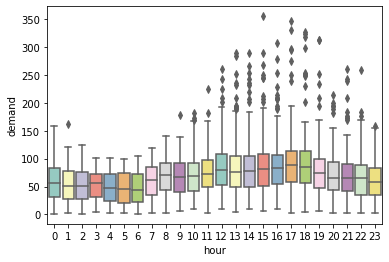

In [7]:

ax = sns.boxplot(x="hour", y=y_train, #hue="isholiday",
                 data=X_train[X_train.isholiday==0], palette="Set3")

In [32]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
for i in range(1,19):
    model =xgb.XGBRegressor( learning_rate = .5/i, max_depth = i, alpha = 10, n_estimators=100, booster='gbtree')
    
    pred=['month','dayofmonth','dayofweek','hour','isholiday']
    X =X_train[pred]
    x_v =X_valid[pred ]
    model.fit(X,y_train)
    y_pred = model.predict(x_v)
    MSE= metrics.mean_squared_error(y_valid,y_pred)
    rmse = np.sqrt(MSE)
    print(i , rmse)
    


1 36.703582069829814
2 35.41313093622728
3 34.65335022148058
4 34.139331832817454
5 33.677695997147644
6 33.50498687047225
7 33.16370792259633
8 33.074255807564825
9 33.12975488263247
10 33.53515867059039
11 33.54050925040977
12 33.64310669712602
13 33.85304037906566
14 34.00749458164542
15 34.187660018487335
16 34.48705011665652
17 34.53522296600245
18 34.56024654064689


In [33]:
i=8
model =xgb.XGBRegressor( learning_rate = .5/i, max_depth = i, alpha = 10, n_estimators=100, booster='gbtree')

model.fit(X_train_b[pred],y_train_b)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0625, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, ...)

In [34]:
sub = X_test.copy()
sub['demand'] = np.round(model.predict(X_test[pred].copy()))
sub[['date','hour','demand']].to_csv('mysub_cat_xgb.csv' , index=False)